# Team

# Danny Phan

# Illya Gordyy

# Loading the dataset

In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from keras.callbacks import TensorBoard
from collections.abc import Sequence

# Load the data
df = pd.read_csv('GOOG.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,2004-08-20,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,2004-08-23,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,2004-08-24,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,2004-08-25,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


# Functions

In [116]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
        
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    
    plt.ylabel('output')
    plt.legend()
    plt.show()

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1) - seq_size):
        # Get the window of features
        window = data1[i:(i + seq_size)]
        # Get the corresponding target value
        after_window = data2[i + seq_size]
        # Append the window and the target value
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Extract features

In [117]:
# Normalize the relevant columns
scaler = MinMaxScaler()


# Create a copy of 'Close' for input features
df['Close_for_input'] = df['Close']  # This is your Close-in equivalent


df[['Open', 'High', 'Low', 'Volume', 'Close_for_input']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Close_for_input']])


# Prepare features and target variable
features = ['Open', 'High', 'Low', 'Volume', 'Close_for_input']  # Using the copied Close for input
target = 'Close'  # Original Close as target

# Replace null values with the median for other features
for column in ['Open', 'High', 'Low', 'Volume', 'Close_for_input']:
    df[column].fillna(df[column].median(), inplace=True)


#Replace null values with the median
for column in features:
    missing_median(df, column)


df = df.dropna(subset=['Open', 'High', 'Low', 'Volume', 'Close_for_input', 'Close'])



# Extract the features and target
data = df[features]
data_out = df[[target]]


# Display the prepared data
print(data.head())
print(data_out.head())





       Open      High       Low    Volume  Close_for_input
0  0.000329  0.000942  0.000000  0.543578         0.000135
1  0.000740  0.002981  0.001877  0.277886         0.003383
2  0.004700  0.004767  0.005413  0.222151         0.003828
3  0.004900  0.004004  0.003147  0.185523         0.001981
4  0.002346  0.002542  0.003275  0.111763         0.002442
       Close
0  49.845802
1  53.805050
2  54.346527
3  52.096165
4  52.657513


C:\Users\Illya\AppData\Local\Temp\ipykernel_9596\736552455.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)


check for missing values, drop date and adj close columns

In [118]:
data.shape

(3578, 5)

In [119]:
data.head()

,Open,High,Low,Volume,Close_for_input
0,0.000329,0.000942,0.000000,0.543578,0.000135
1,0.000740,0.002981,0.001877,0.277886,0.003383
2,0.004700,0.004767,0.005413,0.222151,0.003828
3,0.004900,0.004004,0.003147,0.185523,0.001981
4,0.002346,0.002542,0.003275,0.111763,0.002442


In [120]:
data_out.shape

(3578, 1)

In [121]:
data_out.head()

,Close
0,49.845802
1,53.805050
2,54.346527
3,52.096165
4,52.657513


Null check

In [122]:
print("Remaining missing values:\n", data.isnull().sum())
print("Remaining missing values:\n", data_out.isnull().sum())

Remaining missing values:
 Open               0
High               0
Low                0
Volume             0
Close_for_input    0
dtype: int64
Remaining missing values:
 Close    0
dtype: int64


In [123]:
x = np.array(data.values, dtype = np.float32)
y = np.array(data_out.values, dtype = np.float32)

print(x.shape)
print(y.shape)


(3578, 5)
(3578, 1)


Data Tranformation

In [124]:
SEQUENCE_SIZE = 7

x_seq, y_seq = to_sequences(SEQUENCE_SIZE, x, y)


print("Shape of x_seq: {}".format(x_seq.shape))
print("Shape of y_seq: {}".format(y_seq.shape))

# Reshaping the array
x_seq_reshape = x_seq.reshape(x_seq.shape[0], -1)

print("Shape of x_seq_reshape: {}".format(x_seq_reshape.shape))


Shape of x_seq: (3571, 7, 5)
Shape of y_seq: (3571, 1)
Shape of x_seq_reshape: (3571, 35)


In [125]:
nan_positions_x = np.argwhere(np.isnan(x_seq_reshape))
print("Positions of NaNs in x_seq:", nan_positions_x.sum())

nan_positions_y = np.argwhere(np.isnan(y_seq))
print("Positions of NaNs in y_seq:", nan_positions_y.sum())

Positions of NaNs in x_seq: 0
Positions of NaNs in y_seq: 0


# Fully Connected Neural Network

In [126]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x_seq_reshape, y_seq, test_size=0.30, random_state=42)


In [127]:
x_train.shape

(2499, 35)

In [128]:
x_test.shape

(1072, 35)

In [129]:
y_train.shape

(2499, 1)

In [130]:
y_test.shape

(1072, 1)

In [131]:
print("Number of NaNs in x_train:", np.isnan(x_train).sum())
print("Number of NaNs in x_test:", np.isnan(x_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in y_test:", np.isnan(y_test).sum())

Number of NaNs in x_train: 0
Number of NaNs in x_test: 0
Number of NaNs in y_train: 0
Number of NaNs in y_test: 0


Epoch 1/200


c:\Users\Illya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 - 1s - 11ms/step - loss: 270497.0000 - val_loss: 269622.6875
Epoch 2/200
79/79 - 0s - 1ms/step - loss: 265618.3438 - val_loss: 261620.8906
Epoch 3/200
79/79 - 0s - 1ms/step - loss: 254021.6875 - val_loss: 245464.7344
Epoch 4/200
79/79 - 0s - 1ms/step - loss: 233137.7656 - val_loss: 219284.9844
Epoch 5/200
79/79 - 0s - 1ms/step - loss: 201609.0312 - val_loss: 182304.9688
Epoch 6/200
79/79 - 0s - 1ms/step - loss: 161351.6250 - val_loss: 138621.3594
Epoch 7/200
79/79 - 0s - 1ms/step - loss: 116653.6094 - val_loss: 93645.4688
Epoch 8/200
79/79 - 0s - 1ms/step - loss: 73767.1094 - val_loss: 54577.4961
Epoch 9/200
79/79 - 0s - 1ms/step - loss: 39860.2969 - val_loss: 26951.5566
Epoch 10/200
79/79 - 0s - 1ms/step - loss: 18054.0000 - val_loss: 10891.8613
Epoch 11/200
79/79 - 0s - 1ms/step - loss: 6992.1016 - val_loss: 4213.4883
Epoch 12/200
79/79 - 0s - 1ms/step - loss: 2738.4131 - val_loss: 1974.6211
Epoch 13/200
79/79 - 0s - 1ms/step - loss: 1373.6533 - val_loss: 1259.0269
Epoch 14/200

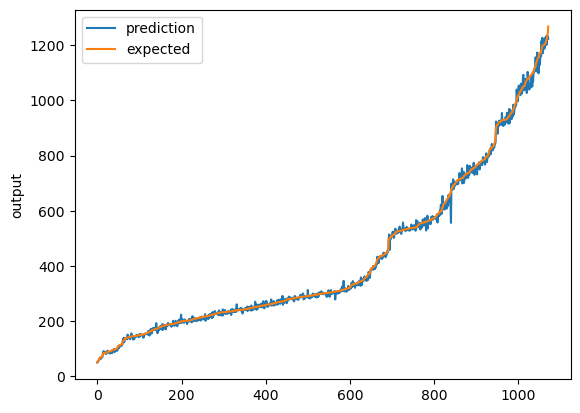

In [132]:
model = Sequential()
model.add(Dense(10, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(filepath = "best_weights.keras", verbose = 0, save_best_only = True)


model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor, checkpointer], verbose = 2, epochs = 200)

#model.load_weights('best_weights.keras')


pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test, y_test))
print("Score_test (RMSE): {}".format(score_test))

# Chart_regression
print("Regression Lift Chart")
chart_regression(pred_test.flatten(), y_test, sort = True)

# CNN

In [133]:
# Create rolling window of size 7
window_size = 7
X = []
y = []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
X = np.array(X)
y = np.array(data_out[0:len(X)].values, dtype = np.float32)

print(X.shape)
print(y.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)

print(y_test.shape)
print(y_train.shape)

(3571, 7, 5)
(3571, 1)
(2499, 7, 5)
(1072, 1)
(2499, 1)


# CNN Model Training

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(7, 5)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1)) 

model.summary()

checkpoint = ModelCheckpoint(filepath="cnn_relu.keras", verbose=1, save_best_only=True) 
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)


c:\Users\Illya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 - 1s - 13ms/step - loss: 249333.0625 - val_loss: 192071.5312
Epoch 2/50
79/79 - 0s - 2ms/step - loss: 78835.9062 - val_loss: 4450.1782
Epoch 3/50
79/79 - 0s - 2ms/step - loss: 2560.4353 - val_loss: 1600.6721
Epoch 4/50
79/79 - 0s - 2ms/step - loss: 1288.3694 - val_loss: 643.4565
Epoch 5/50
79/79 - 0s - 2ms/step - loss: 771.3554 - val_loss: 251.0807
Epoch 6/50
79/79 - 0s - 2ms/step - loss: 556.9202 - val_loss: 131.1356
Epoch 7/50
79/79 - 0s - 2ms/step - loss: 475.4338 - val_loss: 109.2969
Epoch 8/50
79/79 - 0s - 2ms/step - loss: 451.2729 - val_loss: 107.8098
Epoch 9/50
79/79 - 0s - 2ms/step - loss: 454.2448 - val_loss: 106.1704
Epoch 10/50
79/79 - 0s - 2ms/step - loss: 448.1158 - val_loss: 109.0741
Epoch 11/50
79/79 - 0s - 2ms/step - loss: 455.0424 - val_loss: 106.4716
Epoch 12/50
79/79 - 0s - 2ms/step - loss: 434.3820 - val_loss: 103.1232
Epoch 13/50
79/79 - 0s - 2ms/step - loss: 487.7527 - val_loss: 103.3354
Epoch 14/50
79/79 - 0s - 2ms/step - loss: 476.0703 - val_los

In [135]:
y_pred=model.predict(X_test)
y_pred

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[191.38133],
       [292.82315],
       [230.90062],
       ...,
       [199.57181],
       [280.42657],
       [139.19566]], dtype=float32)

In [136]:
X_test.shape


(1072, 7, 5)

In [137]:
array=[]
for i in range(1072):
    array.append(i)
array=np.array(array)
array.shape

(1072,)

# CNN Regression Lift Chart

RMSE:10.385533332824707


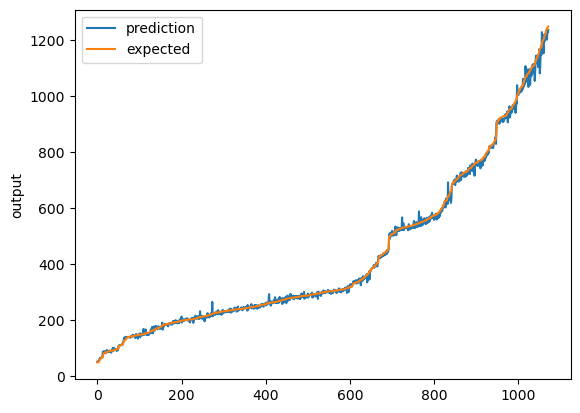

In [138]:
from sklearn.metrics import mean_squared_error as mse
rmse_cnn=np.sqrt(mse(y_test,y_pred))
print(f"RMSE:{rmse_cnn}")
chart_regression(y_pred.flatten(),y_test.flatten(), sort=True)


# LSTM Model

In [150]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

from collections.abc import Sequence
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from sklearn import metrics
import datetime


load data file

In [151]:
df_rnn = pd.read_csv('GOOG.csv')

# Print first and last 5 rows in new csv file
print(df_rnn.head())
print(df_rnn.tail())

print("\nNumber of columns and row:")
print("Data: ", df_rnn.shape)


         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.676899  51.693783  47.669952  49.845802  49.845802  44994500
1  2004-08-20  50.178635  54.187561  49.925285  53.805050  53.805050  23005800
2  2004-08-23  55.017166  56.373344  54.172661  54.346527  54.346527  18393200
3  2004-08-24  55.260582  55.439419  51.450363  52.096165  52.096165  15361800
4  2004-08-25  52.140873  53.651051  51.604362  52.657513  52.657513   9257400
            Date         Open         High          Low        Close  \
3573  2018-10-26  1037.030029  1106.530029  1034.089966  1071.469971   
3574  2018-10-29  1082.469971  1097.040039   995.830017  1020.080017   
3575  2018-10-30  1008.460022  1037.489990  1000.750000  1036.209961   
3576  2018-10-31  1059.810059  1091.939941  1057.000000  1076.770020   
3577  2018-11-01  1075.800049  1083.974976  1062.459961  1070.000000   

        Adj Close   Volume  
3573  1071.469971  4187600  
3574  1020.080017  3880700  
3575  

check for missing values, drop columns Date and Adj close

In [152]:
# Storing in a different dataframe before dropping the columns
df_new = df_rnn

# Check for null values and drop them
df_new.isnull().all(axis=1)
df_new = df_new.dropna()

# Dropping the columns Date and Adj_Close
df_new = df_new.drop(['Date', 'Adj Close'], axis = 1)

# Print first 5 rows of new data frame
print(df_new.head())

print("\nNumber of columns and row currently:")
print("Data: ", df_new.shape)

# Count of NaN in each column
print("\ncount of NaN in each column")
print(df_new.isnull().sum())

        Open       High        Low      Close    Volume
0  49.676899  51.693783  47.669952  49.845802  44994500
1  50.178635  54.187561  49.925285  53.805050  23005800
2  55.017166  56.373344  54.172661  54.346527  18393200
3  55.260582  55.439419  51.450363  52.096165  15361800
4  52.140873  53.651051  51.604362  52.657513   9257400

Number of columns and row currently:
Data:  (3578, 5)

count of NaN in each column
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [153]:
# create a copy of close column
df_new['Copy_Close'] = df_new['Close']

# Print first 5 rows
print(df_new.head())

print("\nNumber of columns and rows currently:")
print("Data: ", df_new.shape)

        Open       High        Low      Close    Volume  Copy_Close
0  49.676899  51.693783  47.669952  49.845802  44994500   49.845802
1  50.178635  54.187561  49.925285  53.805050  23005800   53.805050
2  55.017166  56.373344  54.172661  54.346527  18393200   54.346527
3  55.260582  55.439419  51.450363  52.096165  15361800   52.096165
4  52.140873  53.651051  51.604362  52.657513   9257400   52.657513

Number of columns and rows currently:
Data:  (3578, 6)


normalize numerical features

In [154]:
# Normalizing all the columns except last column Copy_Close
for column in df_new.columns:
  if  column != 'Copy_Close':
    encode_numeric_zscore(df_new, column)

# Print first 5 rows to check normalization
print(df_new.head())

       Open      High       Low     Close    Volume  Copy_Close
0 -1.334844 -1.331443 -1.337457 -1.333645  4.533247   49.845802
1 -1.333101 -1.322843 -1.329562 -1.319893  1.870138   53.805050
2 -1.316291 -1.315305 -1.314693 -1.318012  1.311494   54.346527
3 -1.315446 -1.318526 -1.324223 -1.325828  0.944353   52.096165
4 -1.326284 -1.324693 -1.323684 -1.323879  0.205033   52.657513


In [155]:
# Set all columns other than Copy_Close as input('x')
x = df_new.iloc[:,df_new.columns != 'Copy_Close']
x = np.array(x, dtype = np.float32)

# Set the Copy_Close column as output('y')
y = np.array(df_new['Copy_Close'].values, dtype = np.float32)

print(x.shape)
print(y.shape)

(3578, 5)
(3578,)


Data transformation

In [156]:
SEQUENCE_SIZE = 7

x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

print("Shape of x_lstseq: {}".format(x_lstseq.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

# Reshaping the array
x_newseq = x_lstseq.reshape(x_lstseq.shape[0], 7, 5)

print("Shape of x_newseq: {}".format(x_newseq.shape))

Shape of x_lstseq: (3571, 7, 5)
Shape of y_lstseq: (3571,)
Shape of x_newseq: (3571, 7, 5)


Split train and test 70/30

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size = 0.3, random_state = 0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

Shape of x_train :(2499, 7, 5)
Shape of x_test  :(1072, 7, 5)
Shape of y_train :(2499,)
Shape of y_test  :(1072,)


# Using RNN
Using EarlyStopping, ModelCheckpoint and TensorBoard to plot the training and test loss.

Tuning the following hyperparameters

Activation: relu, sigmoid, tanh
Number of layers and neuron count in each layer
Optimizer: adam and sgd
Number of LSTM layers and neuron count in each layer

Epoch 1/200


c:\Users\Illya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 - 3s - 36ms/step - loss: 224512.1094 - val_loss: 87188.4297
Epoch 2/200
79/79 - 0s - 3ms/step - loss: 26120.1738 - val_loss: 8077.8584
Epoch 3/200
79/79 - 0s - 3ms/step - loss: 4960.7056 - val_loss: 1871.4329
Epoch 4/200
79/79 - 0s - 3ms/step - loss: 2834.3994 - val_loss: 1124.0656
Epoch 5/200
79/79 - 0s - 3ms/step - loss: 2457.0081 - val_loss: 1035.6779
Epoch 6/200
79/79 - 0s - 3ms/step - loss: 2868.5322 - val_loss: 848.1897
Epoch 7/200
79/79 - 0s - 3ms/step - loss: 2607.3774 - val_loss: 804.8806
Epoch 8/200
79/79 - 0s - 3ms/step - loss: 2532.5513 - val_loss: 890.6709
Epoch 9/200
79/79 - 0s - 3ms/step - loss: 2268.6243 - val_loss: 531.2125
Epoch 10/200
79/79 - 0s - 3ms/step - loss: 2587.1643 - val_loss: 25833.5215
Epoch 11/200
79/79 - 0s - 3ms/step - loss: 4626.7993 - val_loss: 620.0579
Epoch 12/200
79/79 - 0s - 3ms/step - loss: 2362.6968 - val_loss: 417.2631
Epoch 13/200
79/79 - 0s - 3ms/step - loss: 2059.7295 - val_loss: 515.4111
Epoch 14/200
79/79 - 0s - 3ms/step - loss: 2135

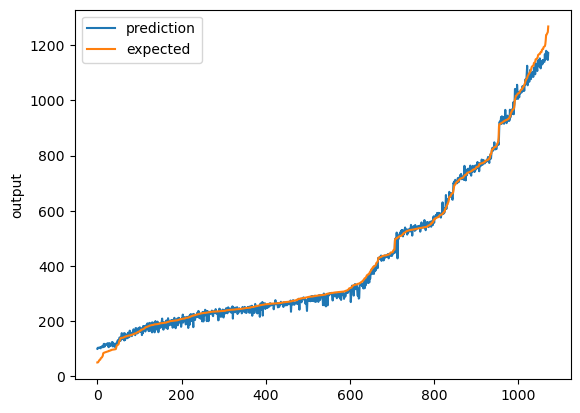

In [159]:

model = Sequential()
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5))) 
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(filepath = "best_weights_LSTM.keras", verbose = 0, save_best_only = True)

model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor, checkpointer], verbose = 2, epochs = 200)

model.load_weights('best_weights_LSTM.keras')  

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test, y_test))
print("Score_test (RMSE): {}".format(score_test))

# Chart_regression
chart_regression(pred_test.flatten(), y_test, sort = True) 

# Additional Features

Bidirectional LSTM

In [160]:
from tensorflow.keras.layers import Bidirectional


In [161]:
checkpoint= ModelCheckpoint(filepath="lstm.keras", verbose=1, save_best_only=True)


model_b = Sequential()
model_b.add(Bidirectional(LSTM(140,return_sequences=True), input_shape=(7,5)))
model_b.add(Bidirectional(LSTM(140),  input_shape=(7,5)))

model_b.add(Dense(1))


model_b.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto')


model_b.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=1000)

Epoch 1/1000


c:\Users\Illya\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 232054.51562, saving model to lstm.keras
79/79 - 5s - 60ms/step - loss: 251331.8906 - val_loss: 232054.5156
Epoch 2/1000

Epoch 2: val_loss improved from 232054.51562 to 214208.18750, saving model to lstm.keras
79/79 - 1s - 7ms/step - loss: 226228.9062 - val_loss: 214208.1875
Epoch 3/1000

Epoch 3: val_loss improved from 214208.18750 to 198838.75000, saving model to lstm.keras
79/79 - 1s - 8ms/step - loss: 209431.8281 - val_loss: 198838.7500
Epoch 4/1000

Epoch 4: val_loss improved from 198838.75000 to 185181.92188, saving model to lstm.keras
79/79 - 1s - 7ms/step - loss: 194537.2656 - val_loss: 185181.9219
Epoch 5/1000

Epoch 5: val_loss improved from 185181.92188 to 172890.32812, saving model to lstm.keras
79/79 - 1s - 7ms/step - loss: 181341.1250 - val_loss: 172890.3281
Epoch 6/1000

Epoch 6: val_loss improved from 172890.32812 to 161965.21875, saving model to lstm.keras
79/79 - 1s - 7ms/step - loss: 169548.7812 - val_loss: 161965.2188
Epoch 7

In [162]:
from sklearn import metrics

# Generate predictions
pred_test_b = model_b.predict(x_test)

# Calculate RMSE
score_test_b = np.sqrt(metrics.mean_squared_error(pred_test_b, y_test))
print("Bidirectional LSTM Test RMSE: {}".format(score_test_b))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Bidirectional LSTM Test RMSE: 8.839563369750977


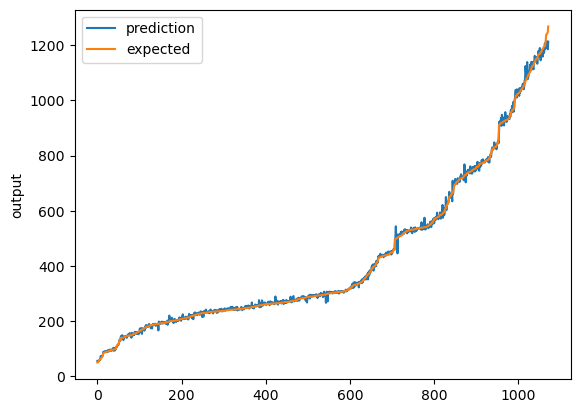

In [163]:
import matplotlib.pyplot as plt
import pandas as pd

chart_regression(pred_test_b.flatten(), y_test.flatten(), sort=True)
